# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [4]:
# from res.plot_lib import plot_data, plot_model, set_default

In [5]:
# set_default()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [8]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 7674203.52it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40271174.81it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 6560707.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7875373.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



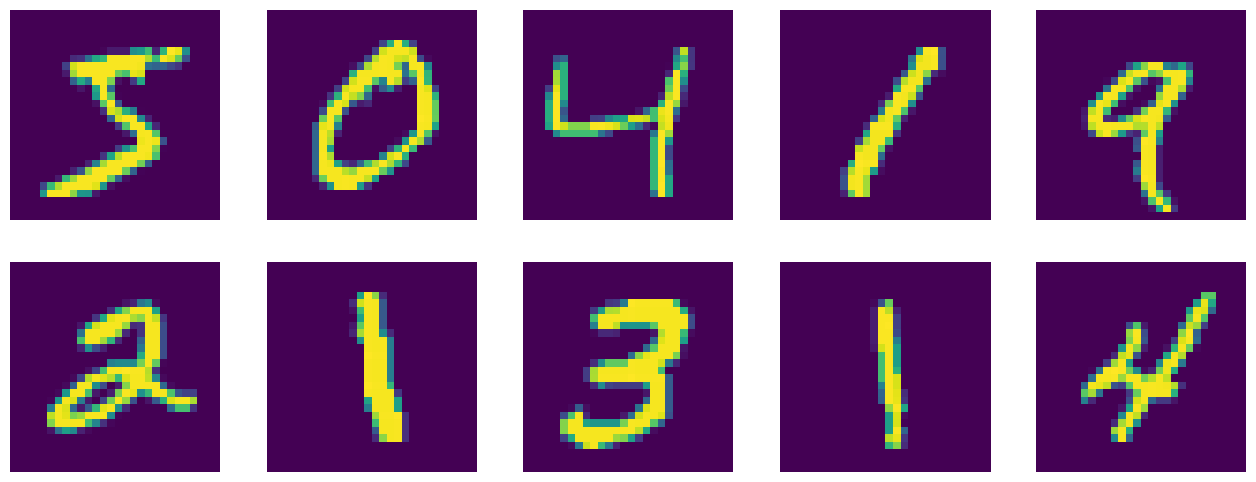

In [9]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [10]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [11]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        print(target)
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [12]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
tensor([1, 8, 0, 2, 1, 7, 4, 1, 9, 6, 9, 1, 3, 0, 8, 0, 8, 1, 6, 7, 5, 6, 4, 2,
        7, 5, 6, 7, 1, 3, 5, 6, 7, 3, 1, 9, 1, 1, 5, 1, 1, 1, 2, 7, 5, 6, 2, 0,
        1, 8, 1, 1, 9, 3, 2, 5, 8, 2, 1, 7, 6, 2, 1, 6])
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.214327
tensor([7, 1, 9, 7, 5, 6, 3, 4, 9, 9, 5, 2, 2, 0, 9, 7, 0, 5, 2, 7, 8, 1, 3, 9,
        0, 7, 7, 7, 4, 0, 0, 3, 7, 7, 6, 6, 2, 5, 8, 2, 4, 5, 7, 5, 3, 8, 6, 8,
        0, 3, 0, 4, 2, 9, 3, 9, 3, 2, 5, 8, 7, 9, 4, 6])
tensor([3, 3, 7, 0, 6, 0, 5, 7, 0, 3, 8, 7, 0, 5, 7, 5, 8, 9, 0, 1, 1, 5, 4, 6,
        3, 5, 9, 6, 6, 1, 7, 1, 6, 8, 7, 6, 2, 8, 5, 6, 9, 1, 9, 9, 6, 4, 4, 8,
        9, 0, 0, 4, 0, 6, 8, 1, 7, 7, 1, 8, 0, 1, 5, 4])
tensor([4, 6, 9, 6, 4, 0, 5, 5, 5, 8, 4, 8, 9, 7, 6, 7, 5, 4, 3, 4, 3, 7, 3, 2,
        5, 9, 0, 4, 7, 9, 6, 1, 8, 3, 8, 1, 8, 9, 0, 9, 0, 3, 9, 1, 2, 9, 3, 1,
        3, 1, 6, 7, 1, 8, 3, 8, 3, 7, 7, 8, 7, 8, 2, 9])
tensor([4, 5, 7, 6, 3, 7, 1, 4, 6, 5, 6, 1, 3, 7, 6, 3, 6, 4

# Train a ConvNet with the same number of parameters

In [13]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
tensor([1, 5, 7, 5, 4, 7, 6, 7, 0, 3, 2, 7, 2, 0, 2, 1, 9, 6, 4, 4, 6, 0, 4, 0,
        2, 9, 9, 3, 7, 9, 5, 2, 8, 8, 6, 5, 3, 7, 2, 7, 2, 6, 4, 7, 9, 6, 9, 2,
        8, 3, 0, 7, 9, 1, 4, 3, 9, 5, 8, 9, 6, 4, 7, 5])
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315431
tensor([2, 4, 7, 7, 9, 0, 8, 4, 7, 8, 2, 3, 5, 3, 1, 1, 2, 9, 2, 9, 9, 3, 5, 2,
        1, 1, 0, 2, 2, 8, 8, 4, 8, 3, 1, 2, 5, 0, 8, 1, 3, 9, 6, 2, 7, 0, 2, 5,
        4, 9, 0, 7, 8, 9, 3, 1, 4, 2, 4, 0, 9, 3, 1, 5])
tensor([7, 0, 1, 2, 6, 3, 6, 3, 4, 5, 4, 1, 2, 7, 1, 2, 0, 2, 0, 7, 0, 8, 5, 7,
        0, 4, 2, 5, 1, 0, 6, 7, 3, 7, 1, 4, 5, 9, 6, 5, 8, 2, 7, 9, 1, 8, 5, 4,
        4, 3, 2, 5, 3, 4, 8, 2, 3, 8, 8, 5, 3, 4, 9, 6])
tensor([5, 2, 2, 2, 6, 3, 4, 7, 6, 4, 7, 7, 2, 1, 3, 5, 9, 8, 9, 6, 1, 1, 0, 8,
        0, 1, 6, 6, 7, 4, 3, 7, 2, 3, 7, 0, 9, 5, 4, 6, 5, 6, 1, 8, 9, 7, 9, 2,
        0, 4, 1, 2, 7, 7, 4, 1, 8, 4, 8, 5, 5, 1, 5, 6])
tensor([9, 3, 0, 0, 1, 4, 1, 0, 8, 7, 1, 5, 3, 7, 3, 1, 7, 5

KeyboardInterrupt: 

# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


In [ ]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

# Fully-Connected with Permuted Pixels

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
plt.title('Performance comparison');

### Checking Model Parameters

In [ ]:
print(dir(model_cnn))

In [ ]:
print(dir(model_fnn))